In [2]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
import matplotlib.pyplot as plt 

In [5]:
uber_df_geo_grid = pd.read_csv('grid_data.csv')
uber_df_geo_grid['date'] = pd.to_datetime(uber_df_geo_grid['date'])
ts= uber_df_geo_grid.groupby('date').grid.count()

In [6]:
training_window = 28
testing_window = 7
total_window_length = training_window + testing_window
x_list  = [] 
y_list = []
for i in range(len(ts.values) - total_window_length):
    x_list.append(ts[i:i+ training_window].values)
    y_list.append(ts[i+ training_window: i+ total_window_length].values)

In [7]:
training_x_array = np.array(x_list[:-8])
training_y_array = np.array(y_list[:-8])
testing_x_array = np.array(x_list[-1:])
testing_y_array = np.array(y_list[-1:])

In [43]:
class lstm(nn.Module):
    def __init__(self,input_size=training_window,hidden_size=64,output_size=testing_window,num_layer=5):
        super(lstm,self).__init__()

        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.layer2 = nn.Linear(hidden_size,output_size)
    def forward(self,x):
        x = x.float()
        x,_ = self.layer1(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x

In [59]:
model = lstm()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [60]:
batch_size_ = 10
train_data = TensorDataset(torch.from_numpy(training_x_array ), torch.from_numpy(training_y_array ))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size_)
test_data = TensorDataset(torch.from_numpy(testing_x_array), torch.from_numpy(testing_y_array ))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size_)

In [61]:
model.train()
for e in range(1000):
    for var_x, var_y in train_loader:
        var_y =var_y.float()
        out = model(var_x.view(-1,10,28).long())
        loss = criterion(out, var_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if e % 50 ==0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, np.mean(loss.data.numpy())))

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([10, 7])) that is different to the input size (torch.Size([1, 10, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 2065050.25000
Epoch: 51, Loss: 1101535.37500
Epoch: 101, Loss: 564278.56250
Epoch: 151, Loss: 429582.75000
Epoch: 201, Loss: 130911.61719
Epoch: 251, Loss: 178582.07812
Epoch: 301, Loss: 191128.18750
Epoch: 351, Loss: 161180.10938
Epoch: 401, Loss: 86171.77344
Epoch: 451, Loss: 162253.48438
Epoch: 501, Loss: 151693.45312
Epoch: 551, Loss: 182881.70312
Epoch: 601, Loss: 192313.76562
Epoch: 651, Loss: 142073.45312
Epoch: 701, Loss: 164259.51562
Epoch: 751, Loss: 179900.07812
Epoch: 801, Loss: 188600.46875
Epoch: 851, Loss: 159901.12500
Epoch: 901, Loss: 167523.65625
Epoch: 951, Loss: 156375.34375


In [62]:
model.eval()
for var_x, var_y in test_loader:
    prediction = model(var_x.view(1,1,28).long())

In [63]:
prediction.detach().numpy()[0][0]

array([1274.9937, 1277.8599, 1274.385 , 1280.0289, 1284.8198, 1289.998 ,
       1295.4163], dtype=float32)

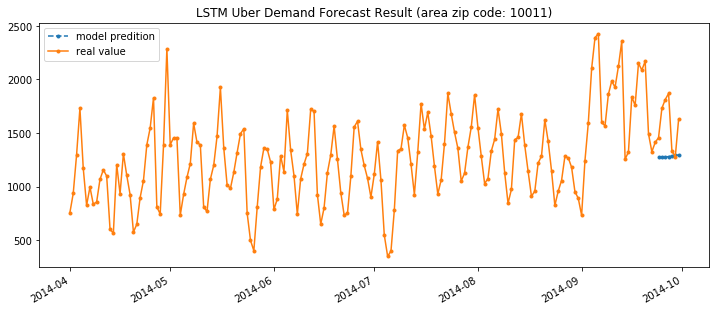

In [64]:
fig = plt.figure(figsize = (12,5))
plt.plot(ts.index[-7:], prediction.detach().numpy()[0][0],label ='model predition',linestyle='--',marker = '.')
plt.plot(ts,label ='real value',marker = '.')
fig.autofmt_xdate()
plt.title('LSTM Uber Demand Forecast Result (area zip code: 10011)')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testing_y_array[0], prediction.detach().numpy()[0][0])

278.1901332310268

In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(testing_y_array[0], prediction.detach().numpy()[0][0])

16.20495039845273